In [2]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import os
import glob
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import math

In [3]:
filename_all = glob.glob("traindata_bc/*.txt")

In [5]:
def readFileasArray(filename):
    f = open ( filename , 'r')
    row_data = []
    row_data = [line.split() for line in f]

    matrix = np.array([])
    matrix.resize((21,21))

    for i in range(len(row_data)):
        col = int(row_data[i][0])
        row = int(row_data[i][1])
        val = float(row_data[i][2])
        matrix[col][row] = val
    return matrix

In [18]:
filename_all = glob.glob("traindata_bc/*.txt")

2.8

In [23]:
filename_all = glob.glob("traindata_bc/*.txt")
list_in = []
list_out = []
for filename in filename_all:
    t = float(filename.split("_")[-1].split(".txt")[0])
    matrix_output = readFileasArray(filename)
    matrix_input_one = np.copy(matrix_output)
    for i in range(1,20):
        for j in range(1,20):
            matrix_input_one[i][j] = -1
        
    matrix_input = np.array([])
    matrix_input.resize((2,21,21))
    matrix_input[0] = matrix_input_one
    matrix_input[1] = t
    matrix_output.resize(1,21,21)
    list_in.append(matrix_input)
    list_out.append(matrix_output)
arr_in = np.array(list_in)
arr_out = np.array(list_out)

In [31]:
train_in = []
train_out = []
test_in = []
test_out = []
for i in range(1000):
    arr_train_in = np.copy(arr_in[(5*i):(5*i+5),:,:,:])
    ten_train_in = torch.from_numpy(arr_train_in)
    train_in.append(ten_train_in)
    
    arr_train_out = np.copy(arr_out[(5*i):(5*i+5),:,:,:]) 
    ten_train_out = torch.from_numpy(arr_train_out)
    train_out.append(ten_train_out)
    
for i in range(200):
    arr_test_in = np.copy(arr_in[(5*i+2000):(5*i+2005),:,:,:])
    ten_test_in = torch.from_numpy(arr_test_in)
    test_in.append(ten_test_in)
    
    arr_test_out = np.copy(arr_out[(5*i+2000):(5*i+2005),:,:,:])
    ten_test_out = torch.from_numpy(arr_test_out)
    test_out.append(ten_test_out)

In [52]:
if not os.path.exists('./dc_img_bc'):
    os.mkdir('./dc_img_bc')

num_epochs = 20
batch_size = 5
learning_rate = 1e-3


class rdcnn(nn.Module):
    def __init__(self):
        super(rdcnn, self).__init__()
        self.discriminator  = nn.Sequential(
            nn.Conv2d(2, 16, 3, stride=2, padding=0),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 2, stride=2),  # b, 8, 10, 10
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2),  # b, 1, 21, 21
            nn.Tanh()
        )

    def forward(self, x):
        x = self.discriminator(x)
        x = self.generator(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = rdcnn().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)
loss_L = []
for epoch in range(num_epochs):
    for i in range(len(train_in)):
        img = train_in[i]
        img = img.float()
        ground_truth = train_out[i]
        ground_truth = ground_truth.float()
        img = Variable(img).to(device)
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, ground_truth)
        
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    loss_L.append(loss)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, loss.data[0]))
    if epoch % 10 == 0:
        save_image(output, './dc_img/image_{}.png'.format(epoch))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [1/20], loss:0.0331
epoch [2/20], loss:0.0205
epoch [3/20], loss:0.0175
epoch [4/20], loss:0.0142
epoch [5/20], loss:0.0083
epoch [6/20], loss:0.0047
epoch [7/20], loss:0.0032
epoch [8/20], loss:0.0025
epoch [9/20], loss:0.0022
epoch [10/20], loss:0.0021
epoch [11/20], loss:0.0018
epoch [12/20], loss:0.0017
epoch [13/20], loss:0.0017
epoch [14/20], loss:0.0017
epoch [15/20], loss:0.0018
epoch [16/20], loss:0.0016
epoch [17/20], loss:0.0015
epoch [18/20], loss:0.0014
epoch [19/20], loss:0.0013
epoch [20/20], loss:0.0012


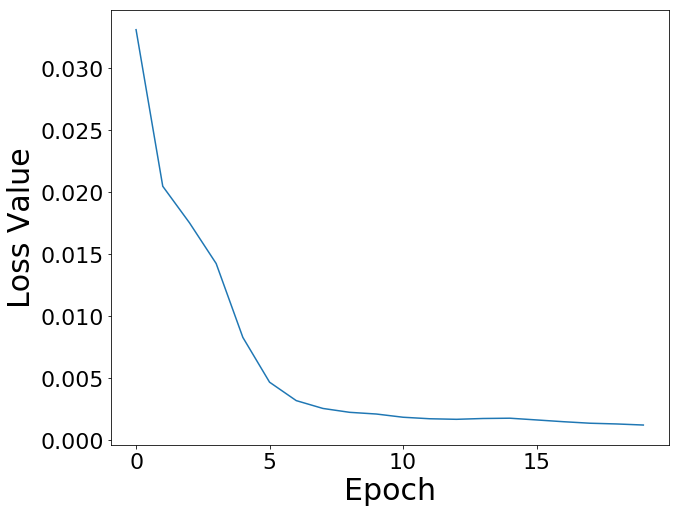

In [239]:
plt.figure(figsize=(10,8))
x = list(range(20))

plt.plot(x, loss_L)
    
# plt.title("Loss ")
plt.xlabel('Epoch', fontsize=30)
plt.ylabel('Loss Value', fontsize=30)
# plt.savefig("loss_tendency", fontsize=20)
plt.rcParams.update({'font.size': 25})
plt.show()

In [7]:
# if not os.path.exists('./test_img'):
#     os.mkdir('./test_img')
# for i in range(len(test_in)):
#     img = test_in[i]
#     img = test_in[i].float()
#     ground_truth = test_out[i]
#     ground_truth = ground_truth.float()
#     img = Variable(img).to(device)

#     output = model(img)

#     loss = criterion(output, ground_truth)

#     save_image(output, './test_img/image_{}.png'.format(i))
#     save_image(ground_truth, './test_img/ground_truth_{}.png'.format(i))


In [55]:
import time
start_time = time.time()
model_output = []
for i in range(len(test_in)):
    img = test_in[i]
    img = test_in[i].float()
    ground_truth = test_out[i]
    ground_truth = ground_truth.float()
    img = Variable(img).to(device)

    output = model(img)
    model_output.append(output)

In [56]:
if not os.path.exists('./test_txt_bc'):
    os.mkdir('./test_txt_bc')

for index in range(200):
    arr_in = test_in[index]
    arr_out = model_output[index].detach()
    array_in = arr_in.numpy()[:, :, :, :]
    array_out = arr_out.numpy()[:, :, :, :]
    
    for piece_index in range(5):
        b3 = array_in[piece_index,0,0,1]
        b4 = array_in[piece_index,0,1,20]
        b1 = array_in[piece_index,0,20,1]
        b2 = array_in[piece_index,0,1,0]
        t = array_in[piece_index,1,0,1]

        write_array = array_out[piece_index,:,:,:].reshape(21,21)

        dir_name = "./test_txt_bc/"
        filename = dir_name + "mesh_"+str(b1)+"_"+str(b2)+"_"+str(b3)+"_"+str(b4)+"_"+str(t)+".txt"
        text = ""
        f = open(filename,"w")
        for i in range(21):
            for j in range (21):
                text = text + str(i) + " " + str(j) + " " + str(write_array[i][j]) +"\n"

        f.write(text) 
        f.close()

In [59]:
filename_all_test = glob.glob("test_txt_bc/*.txt")
filename_all_test.sort(key=str.lower)
filename_all_test

['test_txt_bc/mesh_0.00225704_0.447041_0.708916_0.466061_1.8.txt',
 'test_txt_bc/mesh_0.00225704_0.447041_0.708916_0.466061_1.9.txt',
 'test_txt_bc/mesh_0.00225704_0.447041_0.708916_0.466061_5.8.txt',
 'test_txt_bc/mesh_0.00225704_0.447041_0.708916_0.466061_5.9.txt',
 'test_txt_bc/mesh_0.00225704_0.447041_0.708916_0.466061_7.8.txt',
 'test_txt_bc/mesh_0.00225704_0.447041_0.708916_0.466061_9.1.txt',
 'test_txt_bc/mesh_0.00225704_0.447041_0.708916_0.466061_9.3.txt',
 'test_txt_bc/mesh_0.00225704_0.447041_0.708916_0.466061_9.4.txt',
 'test_txt_bc/mesh_0.00225704_0.447041_0.708916_0.466061_9.5.txt',
 'test_txt_bc/mesh_0.00225704_0.447041_0.708916_0.466061_9.7.txt',
 'test_txt_bc/mesh_0.00296034_0.286657_0.0896753_0.596106_0.1.txt',
 'test_txt_bc/mesh_0.00296034_0.286657_0.0896753_0.596106_0.2.txt',
 'test_txt_bc/mesh_0.00296034_0.286657_0.0896753_0.596106_0.3.txt',
 'test_txt_bc/mesh_0.00296034_0.286657_0.0896753_0.596106_0.5.txt',
 'test_txt_bc/mesh_0.00296034_0.286657_0.0896753_0.596106_

## t changed 

## 所有train出来的数据，按字母顺序粗略排了

In [11]:
filename_all = glob.glob("test_txt/*.txt")
list_t = []
list_t.append(readFileasArray("test_txt/mesh_1_3_0.0.txt"))
list_t.append(readFileasArray("test_txt/mesh_1_3_1.4.txt"))
list_t.append(readFileasArray("test_txt/mesh_1_3_3.6.txt"))
list_t.append(readFileasArray("test_txt/mesh_1_3_5.4.txt"))
list_t.append(readFileasArray("test_txt/mesh_1_3_9.9.txt"))

list_r = []
list_r.append(readFileasArray("traindata/mesh_1_3_0.txt"))
list_r.append(readFileasArray("traindata/mesh_1_3_1.4.txt"))
list_r.append(readFileasArray("traindata/mesh_1_3_3.6.txt"))
list_r.append(readFileasArray("traindata/mesh_1_3_5.4.txt"))
list_r.append(readFileasArray("traindata/mesh_1_3_9.9.txt"))

FileNotFoundError: [Errno 2] No such file or directory: 'test_txt/mesh_1_3_0.0.txt'

## Loss

In [233]:
filename = 'mesh_10_6_10.0.txt'
def loss_one_file(filename):
    if "/" in filename:
        filename = filename.split("/")[1]
        
    trained = readFileasArray("test_txt_bc/"+filename)

    if filename[-5] == "0":
        new_name = filename.split("0.txt")[0]+"txt"
        ground_true = readFileasArray("traindata_bc/"+new_name)
    else:
        ground_true = readFileasArray("traindata_bc/"+filename)
    
    sum_loss = 0
    for i in range(21):
        for j in range(21):
            sum_loss = sum_loss + ((trained[i][j] - ground_true[i][j]))**2
    loss = ((math.sqrt(sum_loss))/441)/np.amax(ground_true )

    return loss

In [198]:
a = loss_one_file(filename_all_test[0])
type(a)

numpy.float64

In [234]:
def loss_for_list_of_file(file_list):
    sum_loss = 0
    for file_name in file_list:
        sum_loss = sum_loss + loss_one_file(file_name)
    return sum_loss/len(file_list)

In [225]:
loss_for_list_of_file(filename_all_test)


0.03093506188096081

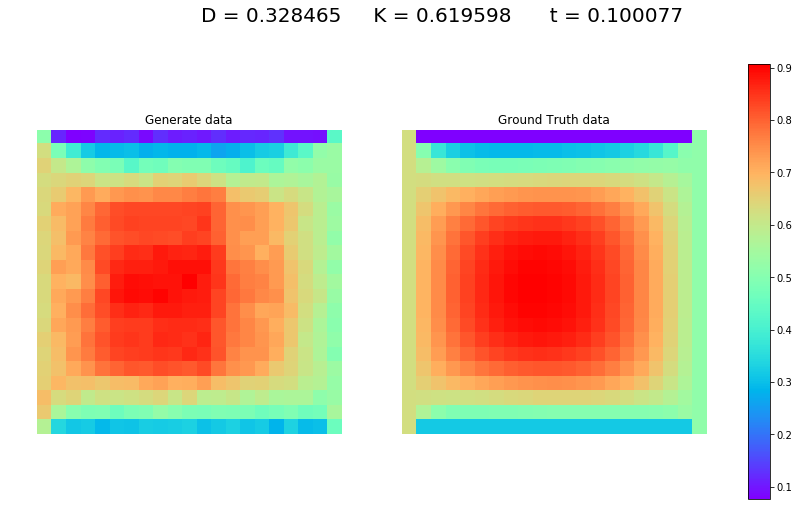

In [61]:
plot_contrast('mesh_0.328465_0.619598_0.100077_0.516096_9.9.txt')

## 所有train出来数据的平均loss

In [17]:

loss_for_list_of_file(filename_all_test)

0.0010993181459482213

## 每个文件对应的loss（用来找质量高的图）

In [18]:
for filename in filename_all_test:
    print(filename,loss_one_file(filename))

test_txt/mesh_10_10_1.4.txt 0.0006303363888314018
test_txt/mesh_10_10_1.5.txt 0.000633118881219163
test_txt/mesh_10_10_1.7.txt 0.0006376475053105844
test_txt/mesh_10_10_3.2.txt 0.0006836302408795615
test_txt/mesh_10_10_3.5.txt 0.000701064577967365
test_txt/mesh_10_10_3.6.txt 0.0007068512669231483
test_txt/mesh_10_10_3.7.txt 0.0007126600348403643
test_txt/mesh_10_10_5.1.txt 0.0007549580990257869
test_txt/mesh_10_10_5.4.txt 0.0007519614796202495
test_txt/mesh_10_10_7.2.txt 0.0007330221572028212
test_txt/mesh_10_10_7.3.txt 0.0007322002819647767
test_txt/mesh_10_1_1.9.txt 0.0005343396446885268
test_txt/mesh_10_1_5.8.txt 0.0004790630769398641
test_txt/mesh_10_1_5.9.txt 0.00047775543831332136
test_txt/mesh_10_1_9.4.txt 0.0004774013785649367
test_txt/mesh_10_1_9.5.txt 0.0004791815013090932
test_txt/mesh_10_3_0.8.txt 0.0006349116662480233
test_txt/mesh_10_3_0.9.txt 0.0006400405801832754
test_txt/mesh_10_3_2.9.txt 0.0006605422444182182
test_txt/mesh_10_3_4.8.txt 0.0005976052957911563
test_txt/m

test_txt/mesh_8_1_3.0.txt 0.0005426881900377847
test_txt/mesh_8_1_3.8.txt 0.0005370087536779565
test_txt/mesh_8_1_6.0.txt 0.0005234442587580916
test_txt/mesh_8_1_7.8.txt 0.0004725376814702151
test_txt/mesh_8_1_7.9.txt 0.0004698355204654199
test_txt/mesh_8_1_9.3.txt 0.00043404700806445705
test_txt/mesh_8_1_9.6.txt 0.0004278039709980426
test_txt/mesh_8_1_9.7.txt 0.00042588792538987097
test_txt/mesh_8_3_0.8.txt 0.0006890493371843342
test_txt/mesh_8_3_1.0.txt 0.0006989446050845261
test_txt/mesh_8_3_2.8.txt 0.0006776354605581747
test_txt/mesh_8_3_2.9.txt 0.0006736790388712603
test_txt/mesh_8_3_4.0.txt 0.0006310735968544054
test_txt/mesh_8_3_6.9.txt 0.0005266589972942544
test_txt/mesh_8_3_8.2.txt 0.0004896909399944181
test_txt/mesh_8_3_8.3.txt 0.0004869258516166165
test_txt/mesh_8_6_0.2.txt 0.0011012138889166126
test_txt/mesh_8_6_0.6.txt 0.0006643461935902334
test_txt/mesh_8_6_0.7.txt 0.0007021383240433751
test_txt/mesh_8_6_2.4.txt 0.0007589460213355052
test_txt/mesh_8_6_2.5.txt 0.0007552631

In [50]:
def plot_contrast(filename):
    para = filename.split("_")
    D = para[1]
    K = para[2]
    t = para[3].split(".txt")[0]

    fig, ax = plt.subplots(1,2, figsize=(15,8))
    ax[0].set_title("Generate data")
    im = ax[0].imshow(readFileasArray("test_txt_bc/"+filename),cmap = 'rainbow' )

    ax[0].axis('off')
    
    f_l = filename.split(".")
    if f_l[1] == "0":
        new_name = f_l[0] + "." + f_l[2]
        ax[1].imshow(readFileasArray("traindata_bc/"+new_name),cmap='rainbow')
    else:
        ax[1].imshow(readFileasArray("traindata_bc/"+filename),cmap='rainbow')
    ax[1].axis('off')
    ax[1].set_title("Ground Truth data")

    fig.colorbar(im, ax=ax.ravel().tolist())

    fig.suptitle("D = "+D+"     K = "+K+"      t = "+t, fontsize=20)
    plt.show()
# ,vmin=-1, vmax=2

In [21]:
for filename in filename_all_test:
    print(filename,loss_one_file(filename))

test_txt/mesh_10_10_1.4.txt 0.0006303363888314018
test_txt/mesh_10_10_1.5.txt 0.000633118881219163
test_txt/mesh_10_10_1.7.txt 0.0006376475053105844
test_txt/mesh_10_10_3.2.txt 0.0006836302408795615
test_txt/mesh_10_10_3.5.txt 0.000701064577967365
test_txt/mesh_10_10_3.6.txt 0.0007068512669231483
test_txt/mesh_10_10_3.7.txt 0.0007126600348403643
test_txt/mesh_10_10_5.1.txt 0.0007549580990257869
test_txt/mesh_10_10_5.4.txt 0.0007519614796202495
test_txt/mesh_10_10_7.2.txt 0.0007330221572028212
test_txt/mesh_10_10_7.3.txt 0.0007322002819647767
test_txt/mesh_10_1_1.9.txt 0.0005343396446885268
test_txt/mesh_10_1_5.8.txt 0.0004790630769398641
test_txt/mesh_10_1_5.9.txt 0.00047775543831332136
test_txt/mesh_10_1_9.4.txt 0.0004774013785649367
test_txt/mesh_10_1_9.5.txt 0.0004791815013090932
test_txt/mesh_10_3_0.8.txt 0.0006349116662480233
test_txt/mesh_10_3_0.9.txt 0.0006400405801832754
test_txt/mesh_10_3_2.9.txt 0.0006605422444182182
test_txt/mesh_10_3_4.8.txt 0.0005976052957911563
test_txt/m

test_txt/mesh_8_1_2.0.txt 0.0005510304882925662
test_txt/mesh_8_1_3.0.txt 0.0005426881900377847
test_txt/mesh_8_1_3.8.txt 0.0005370087536779565
test_txt/mesh_8_1_6.0.txt 0.0005234442587580916
test_txt/mesh_8_1_7.8.txt 0.0004725376814702151
test_txt/mesh_8_1_7.9.txt 0.0004698355204654199
test_txt/mesh_8_1_9.3.txt 0.00043404700806445705
test_txt/mesh_8_1_9.6.txt 0.0004278039709980426
test_txt/mesh_8_1_9.7.txt 0.00042588792538987097
test_txt/mesh_8_3_0.8.txt 0.0006890493371843342
test_txt/mesh_8_3_1.0.txt 0.0006989446050845261
test_txt/mesh_8_3_2.8.txt 0.0006776354605581747
test_txt/mesh_8_3_2.9.txt 0.0006736790388712603
test_txt/mesh_8_3_4.0.txt 0.0006310735968544054
test_txt/mesh_8_3_6.9.txt 0.0005266589972942544
test_txt/mesh_8_3_8.2.txt 0.0004896909399944181
test_txt/mesh_8_3_8.3.txt 0.0004869258516166165
test_txt/mesh_8_6_0.2.txt 0.0011012138889166126
test_txt/mesh_8_6_0.6.txt 0.0006643461935902334
test_txt/mesh_8_6_0.7.txt 0.0007021383240433751
test_txt/mesh_8_6_2.4.txt 0.0007589460

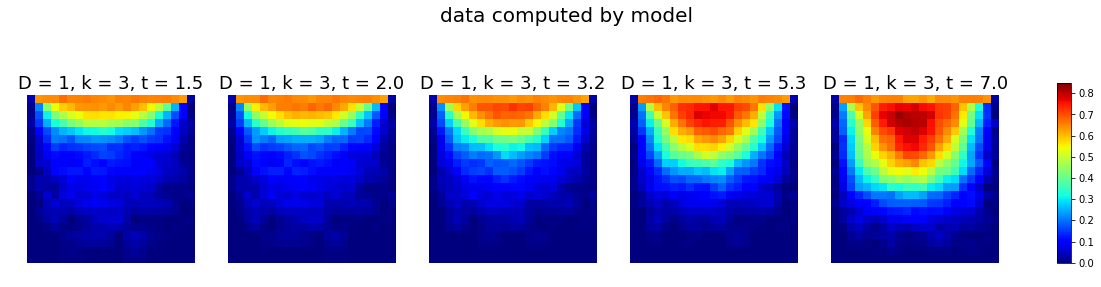

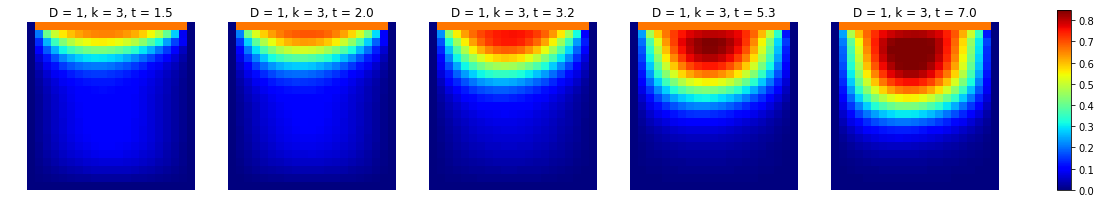

In [163]:
d = "1"
k = "3"
t = ["1.5","2.0","3.2","5.3","7.0"]
Plot_map(d,k,t)

In [170]:
for filename in filename_all_test:
    print(filename,loss_one_file(filename))

test_txt/mesh_10_10_1.4.txt 0.0006303363888314018
test_txt/mesh_10_10_1.5.txt 0.000633118881219163
test_txt/mesh_10_10_1.7.txt 0.0006376475053105844
test_txt/mesh_10_10_3.2.txt 0.0006836302408795615
test_txt/mesh_10_10_3.5.txt 0.000701064577967365
test_txt/mesh_10_10_3.6.txt 0.0007068512669231483
test_txt/mesh_10_10_3.7.txt 0.0007126600348403643
test_txt/mesh_10_10_5.1.txt 0.0007549580990257869
test_txt/mesh_10_10_5.4.txt 0.0007519614796202495
test_txt/mesh_10_10_7.2.txt 0.0007330221572028212
test_txt/mesh_10_10_7.3.txt 0.0007322002819647767
test_txt/mesh_10_1_1.9.txt 0.0005343396446885268
test_txt/mesh_10_1_5.8.txt 0.0004790630769398641
test_txt/mesh_10_1_5.9.txt 0.00047775543831332136
test_txt/mesh_10_1_9.4.txt 0.0004774013785649367
test_txt/mesh_10_1_9.5.txt 0.0004791815013090932
test_txt/mesh_10_3_0.8.txt 0.0006349116662480233
test_txt/mesh_10_3_0.9.txt 0.0006400405801832754
test_txt/mesh_10_3_2.9.txt 0.0006605422444182182
test_txt/mesh_10_3_4.8.txt 0.0005976052957911563
test_txt/m

test_txt/mesh_8_10_5.4.txt 0.0008497720763222989
test_txt/mesh_8_10_5.6.txt 0.0008513680292614467
test_txt/mesh_8_10_5.7.txt 0.0008522416969049613
test_txt/mesh_8_10_7.1.txt 0.0008934513022715265
test_txt/mesh_8_10_7.4.txt 0.0009004081866964384
test_txt/mesh_8_10_7.5.txt 0.0009024366064117068
test_txt/mesh_8_10_7.6.txt 0.0009044928096009457
test_txt/mesh_8_10_9.0.txt 0.0009354177822536473
test_txt/mesh_8_10_9.9.txt 0.0009291883155006563
test_txt/mesh_8_1_2.0.txt 0.0005510304882925662
test_txt/mesh_8_1_3.0.txt 0.0005426881900377847
test_txt/mesh_8_1_3.8.txt 0.0005370087536779565
test_txt/mesh_8_1_6.0.txt 0.0005234442587580916
test_txt/mesh_8_1_7.8.txt 0.0004725376814702151
test_txt/mesh_8_1_7.9.txt 0.0004698355204654199
test_txt/mesh_8_1_9.3.txt 0.00043404700806445705
test_txt/mesh_8_1_9.6.txt 0.0004278039709980426
test_txt/mesh_8_1_9.7.txt 0.00042588792538987097
test_txt/mesh_8_3_0.8.txt 0.0006890493371843342
test_txt/mesh_8_3_1.0.txt 0.0006989446050845261
test_txt/mesh_8_3_2.8.txt 0.0

a = 'test_txt_bc/mesh_0.904817_0.370102_0.28023_0.538247_8.6.txt'
a = 'test_txt_bc/mesh_0.036141_0.976184_0.146641_0.23435_0.8.txt'
a = 'test_txt_bc/mesh_0.270654_0.754736_0.316065_0.773295_7.4.txt'
a = 'test_txt_bc/mesh_0.426421_0.0325609_0.90842_0.798657_7.9.txt'
a =  'test_txt_bc/mesh_0.425357_0.48745_0.616356_0.975167_0.8.txt'
a = 'test_txt_bc/mesh_0.858083_0.281463_0.899007_0.431009_1.8.txt

In [103]:
name = 'test_txt_bc/mesh_0.858083_0.281463_0.899007_0.431009_*.txt'
b = glob.glob(name)

b.sort(key=str.lower)
for filename in b:
    print(filename,loss_one_file(filename))

test_txt_bc/mesh_0.858083_0.281463_0.899007_0.431009_1.8.txt 0.0020141611464393745
test_txt_bc/mesh_0.858083_0.281463_0.899007_0.431009_1.9.txt 0.0020226984949483174
test_txt_bc/mesh_0.858083_0.281463_0.899007_0.431009_10.0.txt 0.0017302089657663248
test_txt_bc/mesh_0.858083_0.281463_0.899007_0.431009_3.8.txt 0.002331822333786522
test_txt_bc/mesh_0.858083_0.281463_0.899007_0.431009_5.8.txt 0.0016946606708710212
test_txt_bc/mesh_0.858083_0.281463_0.899007_0.431009_5.9.txt 0.0017009951398951157
test_txt_bc/mesh_0.858083_0.281463_0.899007_0.431009_9.1.txt 0.0016644627229632824
test_txt_bc/mesh_0.858083_0.281463_0.899007_0.431009_9.4.txt 0.0016899153004001728
test_txt_bc/mesh_0.858083_0.281463_0.899007_0.431009_9.5.txt 0.0016996542389289132


In [190]:
## 'test_txt_bc/mesh_0.904817_0.370102_0.28023_0.538247_8.6.txt'
d1_1 = "0.904817"
d2_1 = "0.370102"
d3_1 = "0.28023"
d4_1 = "0.538247"
t1 = ["2.0","4.8","6.0","7.0","8.7"]

## 'test_txt_bc/mesh_0.036141_0.976184_0.146641_0.23435_0.8.txt'
d1_2 = "0.036141"
d2_2 = "0.976184"
d3_2 = "0.146641"
d4_2 = "0.23435"
t2 = ["0.8","2.8","4.8","8.1","8.5"]

## 'test_txt_bc/mesh_0.270654_0.754736_0.316065_0.773295_7.4.txt'
d1_3 = "0.270654"
d2_3 = "0.754736"
d3_3 = "0.316065"
d4_3 = "0.773295"
t3 = ["1.4","3.4","5.4","7.5","9.9"]

## 'test_txt_bc/mesh_0.426421_0.0325609_0.90842_0.798657_7.9.txt'
d1_4 = "0.426421"
d2_4 = "0.0325609"
d3_4 = "0.90842"
d4_4 = "0.798657"
t4 = ["1.9","5.9","7.9","9.1","9.6"]

## 'test_txt_bc/mesh_0.425357_0.48745_0.616356_0.975167_0.8.txt'
d1_5 = "0.425357"
d2_5 = "0.48745"
d3_5 = "0.616356"
d4_5 = "0.975167"
t5 = ["0.8","2.9","4.8","8.1","8.5"]

## 'test_txt_bc/mesh_0.858083_0.281463_0.899007_0.431009_1.8.txt'
d1_6 = "0.858083"
d2_6 = "0.281463"
d3_6 = "0.899007"
d4_6 = "0.431009"
t6 = ["1.8","3.8","5.8","9.1","10.0"]

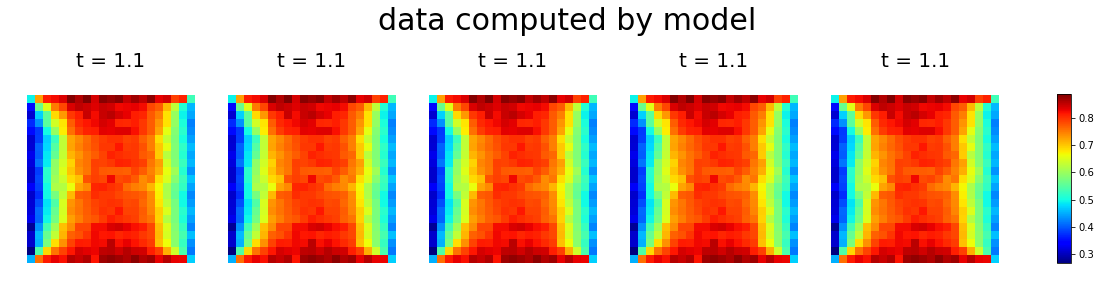

In [122]:
fig, ax = plt.subplots(1,5, figsize=(20,5))
for i in range(5):
    
    im = ax[i].imshow(readFileasArray("test_txt_bc/mesh_0.858083_0.281463_0.899007_0.431009_9.5.txt"),cmap = "jet")
    
    ax[i].axis('off')
    ax[i].set_title("t = 1.1\n ",size=20)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.47])
fig.colorbar(im, cax=cbar_ax)

fig.suptitle("data computed by model", fontsize=30)
# plt.savefig("1.pdf")

# plt.subplots_adjust(top=0.5)
plt.show()

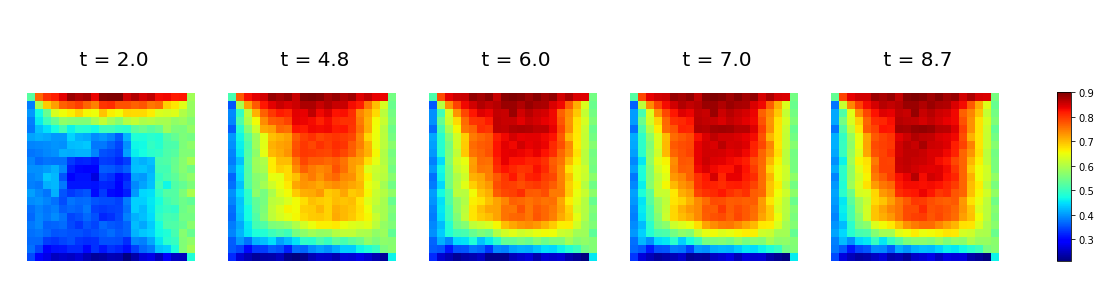

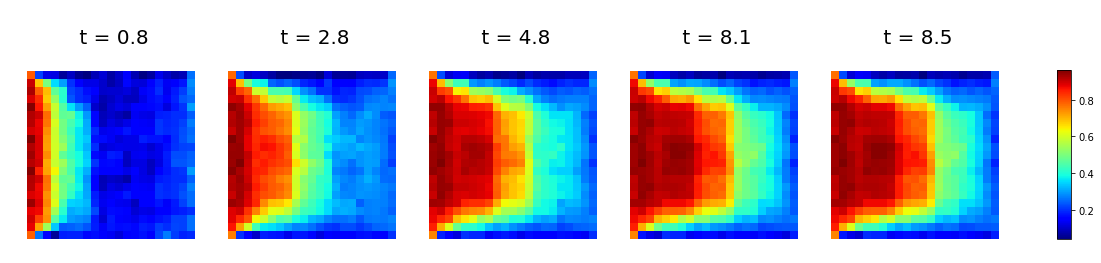

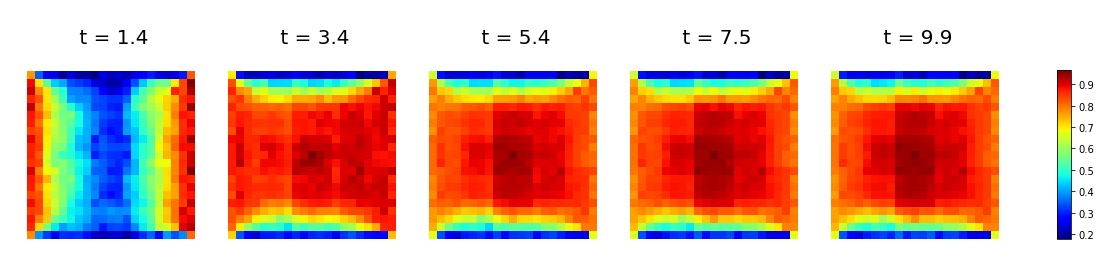

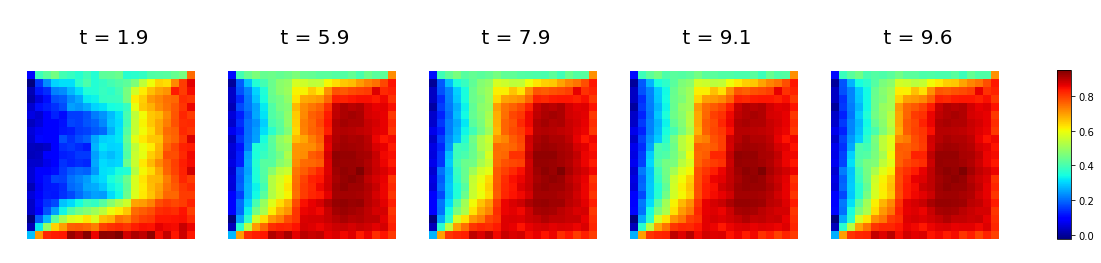

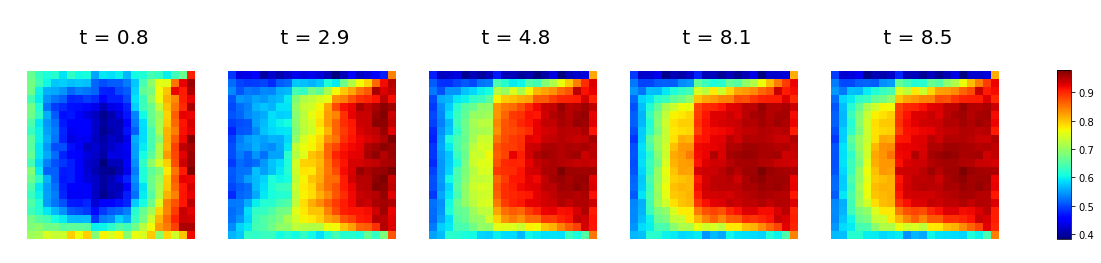

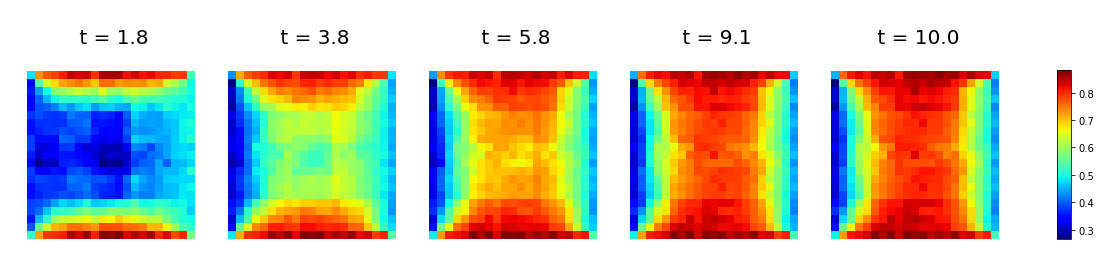

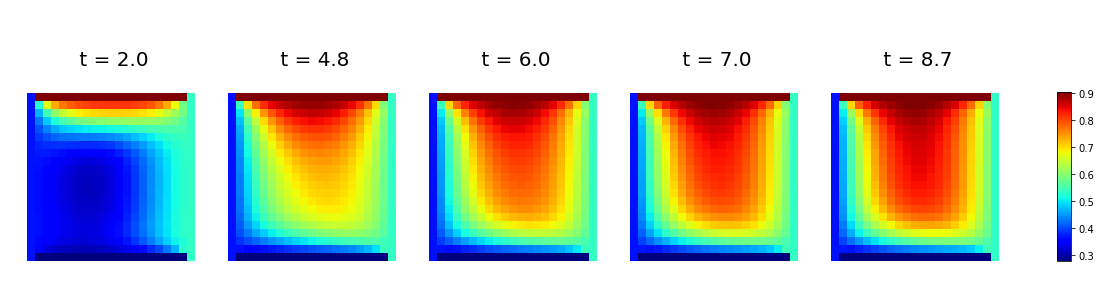

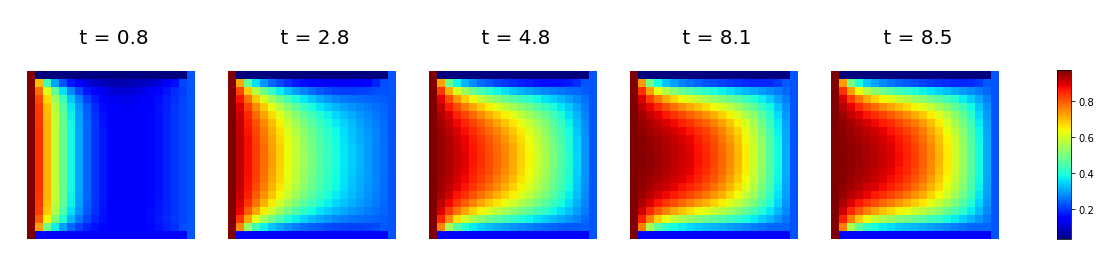

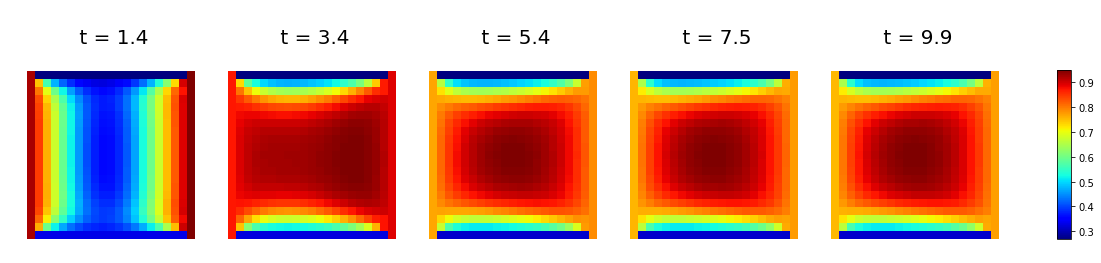

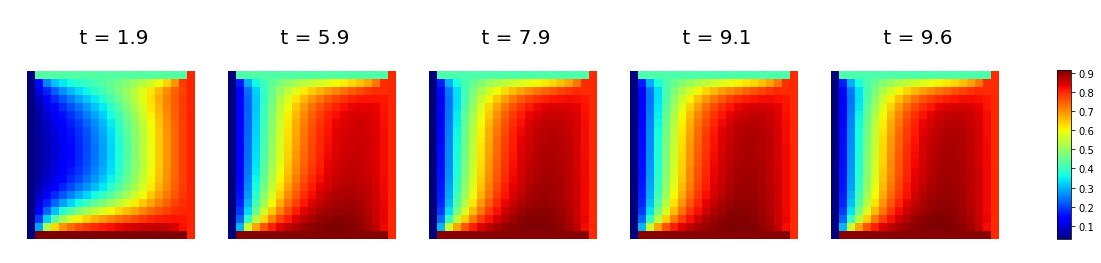

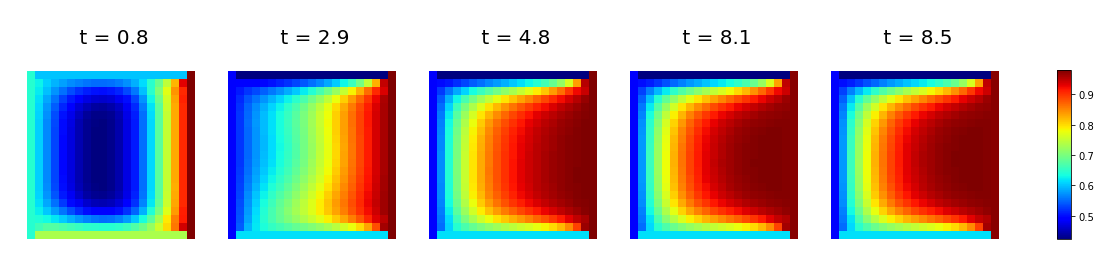

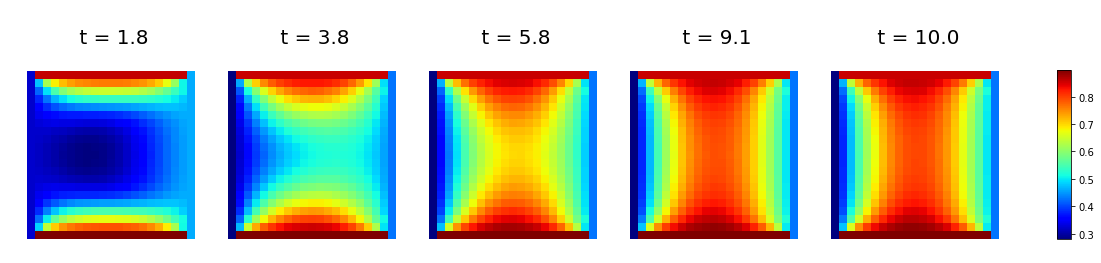

In [192]:

f = []



d1_6 = "0.858083"
d2_6 = "0.281463"
d3_6 = "0.899007"
d4_6 = "0.431009"
t6 
for t_e in t1:
    f.append("test_txt_bc/mesh_"+d1_1+"_"+d2_1+"_"+d3_1+"_"+d4_1+"_"+t_e+".txt")
    
for t_e in t2:
    f.append("test_txt_bc/mesh_"+d1_2+"_"+d2_2+"_"+d3_2+"_"+d4_2+"_"+t_e+".txt")
    
for t_e in t3:
    f.append("test_txt_bc/mesh_"+d1_3+"_"+d2_3+"_"+d3_3+"_"+d4_3+"_"+t_e+".txt")
    
for t_e in t4:
    f.append("test_txt_bc/mesh_"+d1_4+"_"+d2_4+"_"+d3_4+"_"+d4_4+"_"+t_e+".txt")
    
for t_e in t5:
    f.append("test_txt_bc/mesh_"+d1_5+"_"+d2_5+"_"+d3_5+"_"+d4_5+"_"+t_e+".txt")
    
for t_e in t6:
    f.append("test_txt_bc/mesh_"+d1_6+"_"+d2_6+"_"+d3_6+"_"+d4_6+"_"+t_e+".txt")

list_t = []    
list_r = []


for i in f:
    filename = i.split("/")[1]
    list_t.append(readFileasArray("test_txt_bc/"+filename))
    
    if filename[-5] == "0":
        new_name = filename.split("0.txt")[0]+"txt"
        list_r.append(readFileasArray("traindata_bc/"+new_name))
    else:
        list_r.append(readFileasArray("traindata_bc/"+filename))

        
# -------------------- train-1 -------------------------#
fig, ax = plt.subplots(1,5, figsize=(20,5))
for i in range(5):
    
    im = ax[i].imshow(list_t[i][::-1],cmap = "jet")
    ax[i].set_title("\n \n t = "+t1[i]+"\n ",size=20)
    ax[i].axis('off')
#     ax[i].set_title("D = "+d1+", k = "+k1+", t = "+t1[i],size=16)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.47])
fig.colorbar(im, cax=cbar_ax)

# fig.suptitle("Prediction", fontsize=30)
# plt.savefig("1.pdf")
plt.show()


# -------------------- train-2 -------------------------#
fig, ax = plt.subplots(1,5, figsize=(20,5))
for i in range(5):
    im = ax[i].imshow(list_t[i+5][::-1],cmap = "jet")
    ax[i].axis('off')
    ax[i].set_title("\n t = "+t2[i]+"\n ",size=20)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.47])
fig.colorbar(im, cax=cbar_ax)

# plt.savefig("1.pdf")
plt.show()

# -------------------- train-3 -------------------------#
fig, ax = plt.subplots(1,5, figsize=(20,5))
for i in range(5):
    im = ax[i].imshow(list_t[i+10][::-1],cmap = "jet")
    ax[i].axis('off')
    ax[i].set_title("\n t = "+t3[i]+"\n ",size=20)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.47])
fig.colorbar(im, cax=cbar_ax)

# plt.savefig("1.pdf")
plt.show()

# -------------------- train-4 -------------------------#
fig, ax = plt.subplots(1,5, figsize=(20,5))
for i in range(5):
    im = ax[i].imshow(list_t[i+15][::-1],cmap = "jet")
    ax[i].axis('off')
    ax[i].set_title("\n t = "+t4[i]+"\n ",size=20)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.47])
fig.colorbar(im, cax=cbar_ax)

plt.show()

# -------------------- train-5 -------------------------#
fig, ax = plt.subplots(1,5, figsize=(20,5))
for i in range(5):
    im = ax[i].imshow(list_t[i+20][::-1],cmap = "jet")
    ax[i].axis('off')
    ax[i].set_title("\n t = "+t5[i]+"\n ",size=20)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.47])
fig.colorbar(im, cax=cbar_ax)

# plt.savefig("1.pdf")
plt.show()

# -------------------- train-6 -------------------------#
fig, ax = plt.subplots(1,5, figsize=(20,5))
for i in range(5):
    im = ax[i].imshow(list_t[i+25][::-1],cmap = "jet")
    ax[i].axis('off')
    ax[i].set_title("\n t = "+t6[i]+"\n ",size=20)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.47])
fig.colorbar(im, cax=cbar_ax)

plt.show()

# -------------------- truth-1 -------------------------#
fig, ax = plt.subplots(1,5, figsize=(20,5))
fig.subplots_adjust(right=0.8)
for i in range(5):
    im = ax[i].imshow(list_r[i][::-1],cmap = "jet")
    ax[i].axis('off')
    ax[i].set_title("\n \n t = "+t1[i]+"\n ",size=20)
cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.47])
fig.colorbar(im, cax=cbar_ax)

# fig.suptitle("Ground Truth", fontsize=30)
plt.show()


# -------------------- truth-2 -------------------------#
fig, ax = plt.subplots(1,5, figsize=(20,5))
for i in range(5):
    im = ax[i].imshow(list_r[i+5][::-1],cmap = "jet")
    ax[i].axis('off')
    ax[i].set_title("\n t = "+t2[i]+"\n ",size=20)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.47])
fig.colorbar(im, cax=cbar_ax)

plt.show()

# -------------------- truth-3 -------------------------#
fig, ax = plt.subplots(1,5, figsize=(20,5))
for i in range(5):
    im = ax[i].imshow(list_r[i+10][::-1],cmap = "jet")
    ax[i].axis('off')
    ax[i].set_title("\n t = "+t3[i]+"\n ",size=20)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.47])
fig.colorbar(im, cax=cbar_ax)

plt.show()

# -------------------- train-4 -------------------------#
fig, ax = plt.subplots(1,5, figsize=(20,5))
for i in range(5):
    im = ax[i].imshow(list_r[i+15][::-1],cmap = "jet")
    ax[i].axis('off')
    ax[i].set_title("\n t = "+t4[i]+"\n ",size=20)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.47])
fig.colorbar(im, cax=cbar_ax)

plt.show()

# -------------------- train-5 -------------------------#
fig, ax = plt.subplots(1,5, figsize=(20,5))
for i in range(5):
    im = ax[i].imshow(list_r[i+20][::-1],cmap = "jet")
    ax[i].axis('off')
    ax[i].set_title("\n t = "+t5[i]+"\n ",size=20)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.47])
fig.colorbar(im, cax=cbar_ax)

# plt.savefig("1.pdf")
plt.show()

# -------------------- truth-6 -------------------------#
fig, ax = plt.subplots(1,5, figsize=(20,5))
for i in range(5):
    im = ax[i].imshow(list_r[i+25][::-1],cmap = "jet")
    ax[i].axis('off')
    ax[i].set_title("\n t = "+t6[i]+"\n ",size=20)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.47])
fig.colorbar(im, cax=cbar_ax)

plt.show()


In [236]:
n = [[],[],[],[],[],[]]
# a = 'test_txt_bc/mesh_0.904817_0.370102_0.28023_0.538247_8.6.txt'
# a = 'test_txt_bc/mesh_0.036141_0.976184_0.146641_0.23435_0.8.txt'
# a = 'test_txt_bc/mesh_0.270654_0.754736_0.316065_0.773295_7.4.txt'
# a = 'test_txt_bc/mesh_0.426421_0.0325609_0.90842_0.798657_7.9.txt'
# a =  'test_txt_bc/mesh_0.425357_0.48745_0.616356_0.975167_0.8.txt'
n[0] = glob.glob("test_txt_bc/mesh_0.904817_0.370102_0.28023_0.538247_*.txt")

n[1] = glob.glob("test_txt_bc/mesh_0.036141_0.976184_0.146641_0.23435_*.txt")

n[2] = glob.glob("test_txt_bc/mesh_0.270654_0.754736_0.316065_0.773295_*.txt")

n[3] = glob.glob("test_txt_bc/mesh_0.426421_0.0325609_0.90842_0.798657_*.txt")

n[4] =glob.glob("test_txt_bc/mesh_0.425357_0.48745_0.616356_0.975167*.txt")

n[5] = glob.glob("test_txt_bc/mesh_0.858083_0.281463_0.899007_0.431009_*.txt")
y = []
for i in range(6):
    y.append(loss_for_list_of_file(n[i]))

x = [10,6,2.67,0.6,0.33,0.125]



# plt.plot(x, y)
    
# plt.xlabel('d/k')

# plt.ylabel('Loss Value')
# plt.savefig("loss_tendency")
# plt.show()
y

[0.0014153061932492994,
 0.0027409005604443495,
 0.0016521165165952346,
 0.002497954283002699,
 0.0017982640028428559,
 0.0018387310015554495]

In [ ]:
d = "10"
k = "1"
t = ["1.9","5.8","5.9","9.4","9.5"]



fig, ax = plt.subplots(1,5, figsize=(20,5))
for i in range(5):
    im = ax[i].imshow(list_t[i][::-1],cmap = "jet",vmin=v_min, vmax=v_max)
    ax[i].axis('off')
    ax[i].set_title("D = "+d+", k = "+k+", t = "+t[i],size=18)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.5])
fig.colorbar(im, cax=cbar_ax)
#     fig.colorbar(im,fraction=0.046, pad=0.04)
#     fig.colorbar(im, ax=ax[-1])

fig.suptitle("data computed by model", fontsize=20)
plt.savefig("1.pdf")
plt.show()

fig, ax = plt.subplots(1,5, figsize=(20,5))
fig.subplots_adjust(right=0.8)
for i in range(5):
    im = ax[i].imshow(list_r[i][::-1],cmap = "jet",vmin=v_min, vmax=v_max)
    ax[i].axis('off')
    ax[i].set_title("D = "+d+", k = "+k+", t = "+t[i])
cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.5])
fig.colorbar(im, cax=cbar_ax)
#     fig.suptitle("ground truth data", fontsize=20)
plt.savefig("2.pdf")
plt.show()



## Accuracy

In [79]:
for file_name in filename_all:
    if file_name.split("_")[3] == '0.txt':
        print(file_name)

# len(filename_test)
# filename_test[1]

traindata/mesh_10_6_0.txt
traindata/mesh_8_10_0.txt
traindata/mesh_3_8_0.txt
traindata/mesh_3_10_0.txt
traindata/mesh_6_6_0.txt
traindata/mesh_1_8_0.txt
traindata/mesh_6_1_0.txt
traindata/mesh_6_3_0.txt
traindata/mesh_10_10_0.txt
traindata/mesh_8_8_0.txt
traindata/mesh_10_1_0.txt
traindata/mesh_10_3_0.txt
traindata/mesh_1_10_0.txt
traindata/mesh_1_6_0.txt
traindata/mesh_3_3_0.txt
traindata/mesh_8_6_0.txt
traindata/mesh_3_1_0.txt
traindata/mesh_8_1_0.txt
traindata/mesh_3_6_0.txt
traindata/mesh_1_3_0.txt
traindata/mesh_1_1_0.txt
traindata/mesh_8_3_0.txt
traindata/mesh_6_8_0.txt
traindata/mesh_6_10_0.txt
traindata/mesh_10_8_0.txt


## input

In [ ]:
d1_1 = "0.904817"
d2_1 = "0.370102"
d3_1 = "0.28023"
d4_1 = "0.538247"
t1 = ["2.0","4.8","6.0","7.0","8.7"]

## 'test_txt_bc/mesh_0.036141_0.976184_0.146641_0.23435_0.8.txt'
d1_2 = "0.036141"
d2_2 = "0.976184"
d3_2 = "0.146641"
d4_2 = "0.23435"
t2 = ["0.8","2.8","4.8","8.1","8.5"]

## 'test_txt_bc/mesh_0.270654_0.754736_0.316065_0.773295_7.4.txt'
d1_3 = "0.270654"
d2_3 = "0.754736"
d3_3 = "0.316065"
d4_3 = "0.773295"
t3 = ["1.4","3.4","5.4","7.5","9.9"]

## 'test_txt_bc/mesh_0.426421_0.0325609_0.90842_0.798657_7.9.txt'
d1_4 = "0.426421"
d2_4 = "0.0325609"
d3_4 = "0.90842"
d4_4 = "0.798657"
t4 = ["1.9","5.9","7.9","9.1","9.6"]

## 'test_txt_bc/mesh_0.425357_0.48745_0.616356_0.975167_0.8.txt'
d1_5 = "0.425357"
d2_5 = "0.48745"
d3_5 = "0.616356"
d4_5 = "0.975167"
t5 = ["0.8","2.9","4.8","8.1","8.5"]

## 'test_txt_bc/mesh_0.858083_0.281463_0.899007_0.431009_1.8.txt'
d1_6 = "0.858083"
d2_6 = "0.281463"
d3_6 = "0.899007"
d4_6 = "0.431009"

In [146]:
def return_input(l):
    for i in range(1,20):
        for j in range(1,20):
            l[i][j] = -1
    return l

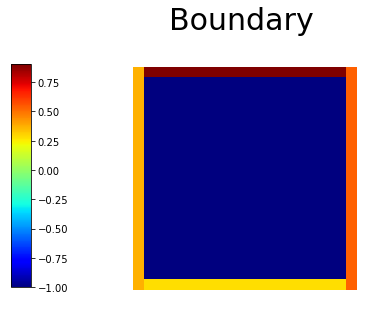

In [226]:
d1_1 = "0.90"
d2_1 = "0.37"
d3_1 = "0.28"
d4_1 = "0.54"
fig, ax = plt.subplots(1,1, figsize=(4,5))

matrix  = readFileasArray("traindata_bc/mesh_0.904817_0.370102_0.28023_0.538247_8.6.txt")
im = ax.imshow(return_input(matrix[::-1]),cmap = "jet")
# ax.set_title("\n"+"u1 = "+d1_1+"    u2 = "+d2_1+"    u3 = "+d3_1+"    u4 = "+d4_1+"\n",size=20)
ax.axis('off')

cbar_ax = fig.add_axes([-0.3, 0.2, 0.07, 0.62])
fig.colorbar(im, cax=cbar_ax)
fig.suptitle("Boundary", fontsize=30)
plt.show()

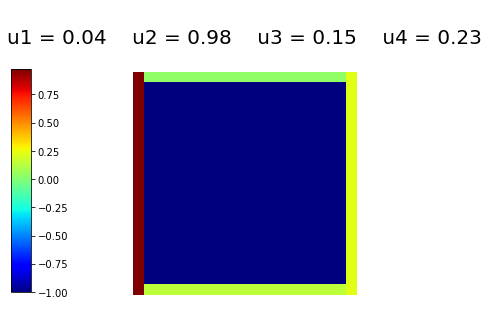

In [220]:
d1_2 = "0.04"
d2_2 = "0.98"
d3_2 = "0.15"
d4_2 = "0.23"
fig, ax = plt.subplots(1,1, figsize=(4,5))

matrix  = readFileasArray('traindata_bc/mesh_0.036141_0.976184_0.146641_0.23435_0.8.txt')
im = ax.imshow(return_input(matrix[::-1]),cmap = "jet")
ax.set_title("\n"+"u1 = "+d1_2+"    u2 = "+d2_2+"    u3 = "+d3_2+"    u4 = "+d4_2+"\n",size=20)
ax.axis('off')

cbar_ax = fig.add_axes([-0.3, 0.2, 0.07, 0.62])
fig.colorbar(im, cax=cbar_ax)

plt.show()

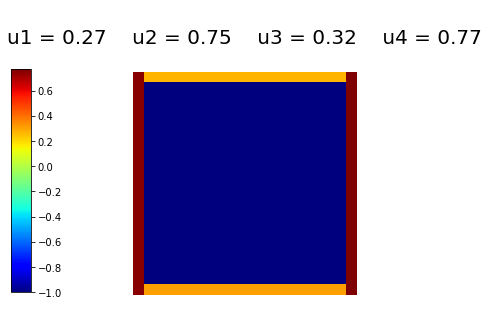

In [227]:
d1_3 = "0.27"
d2_3 = "0.75"
d3_3 = "0.32"
d4_3 = "0.77"
fig, ax = plt.subplots(1,1, figsize=(4,5))

matrix  = readFileasArray('traindata_bc/mesh_0.270654_0.754736_0.316065_0.773295_7.4.txt')

im = ax.imshow(return_input(matrix[::-1]),cmap = "jet")
ax.set_title("\n"+"u1 = "+d1_3+"    u2 = "+d2_3+"    u3 = "+d3_3+"    u4 = "+d4_3+"\n",size=20)
ax.axis('off')

cbar_ax = fig.add_axes([-0.3, 0.2, 0.07, 0.62])
fig.colorbar(im, cax=cbar_ax)

plt.show()

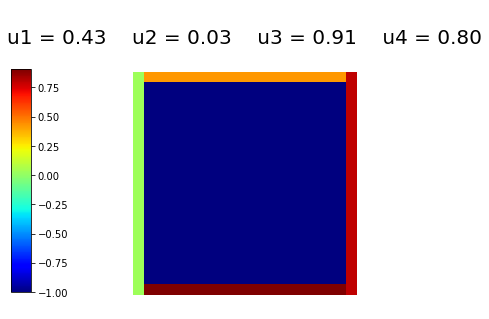

In [228]:
d1_4 = "0.43"
d2_4 = "0.03"
d3_4 = "0.91"
d4_4 = "0.80"


fig, ax = plt.subplots(1,1, figsize=(4,5))

matrix = readFileasArray('traindata_bc/mesh_0.426421_0.0325609_0.90842_0.798657_7.9.txt')
im = ax.imshow(return_input(matrix[::-1]),cmap = "jet")
ax.set_title("\n"+"u1 = "+d1_4+"    u2 = "+d2_4+"    u3 = "+d3_4+"    u4 = "+d4_4+"\n",size=20)
ax.axis('off')

cbar_ax = fig.add_axes([-0.3, 0.2, 0.07, 0.62])
fig.colorbar(im, cax=cbar_ax)

plt.show()

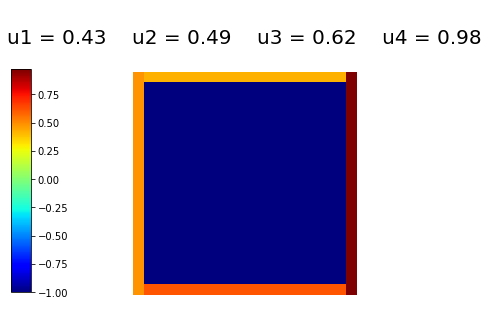

In [229]:
d1_5 = "0.43"
d2_5 = "0.49"
d3_5 = "0.62"
d4_5 = "0.98"


matrix = readFileasArray('traindata_bc/mesh_0.425357_0.48745_0.616356_0.975167_0.8.txt')
fig, ax = plt.subplots(1,1, figsize=(4,5))

    
im = ax.imshow(return_input(matrix[::-1]),cmap = "jet")
ax.set_title("\n"+"u1 = "+d1_5+"    u2 = "+d2_5+"    u3 = "+d3_5+"    u4 = "+d4_5+"\n",size=20)
ax.axis('off')

cbar_ax = fig.add_axes([-0.3, 0.2, 0.07, 0.62])
fig.colorbar(im, cax=cbar_ax)

plt.show()

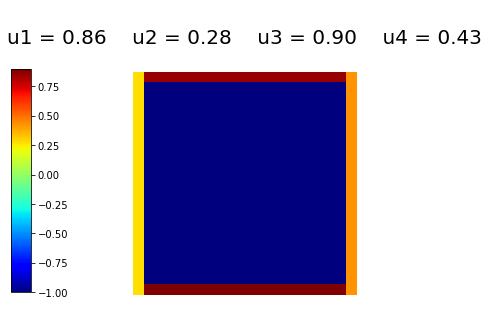

In [230]:
d1_6 = "0.86"
d2_6 = "0.28"
d3_6 = "0.90"
d4_6 = "0.43"


fig, ax = plt.subplots(1,1, figsize=(4,5))

matrix = readFileasArray( 'traindata_bc/mesh_0.858083_0.281463_0.899007_0.431009_1.8.txt')
im = ax.imshow(return_input(matrix[::-1]),cmap = "jet")
ax.set_title("\n"+"u1 = "+d1_6+"    u2 = "+d2_6+"    u3 = "+d3_6+"    u4 = "+d4_6+"\n",size=20)
ax.axis('off')

cbar_ax = fig.add_axes([-0.3, 0.2, 0.07, 0.62])
fig.colorbar(im, cax=cbar_ax)

plt.show()